In [1]:
%pip install -U gym>=0.21.0
%pip install -U gym[atari,accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=67f5e7fedbe07b98b8cbbc4b916cf790cf354018ad4246cac52858b1869b4eed
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license


In [2]:
import tensorflow as tf
import gym
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import datetime, os

In [3]:
from gym.wrappers import AtariPreprocessing

In [4]:
class ScaledFloatFrame(gym.ObservationWrapper):
     def observation(self, obs):
         return np.array(obs).astype(np.float32) / 255.0

In [14]:
env = gym.make("ALE/Phoenix-v5")
env = AtariPreprocessing(env, frame_skip=1, grayscale_newaxis=True)
env = ScaledFloatFrame(env)

In [15]:
class DQN(keras.models.Model):
    
    def __init__(self, num_actions, dueling = False, noisy = False, stdv = 0.9):
        super().__init__()
        
        self.num_actions = num_actions
        self.dueling = dueling
        self.noisy = noisy
        self.stdv = stdv

        if self.dueling:

          self.v_network = keras.layers.Dense(1, activation = "relu")
          self.advantage = keras.layers.Dense(num_actions)

        #Convolutional Layers
        self.conv1 = keras.layers.Conv2D(32, kernel_size = (4,4), strides=(2,2), padding="same", activation="relu")
        self.batchn1 = keras.layers.BatchNormalization()
        self.conv2 = keras.layers.Conv2D(64, kernel_size = (4,4), strides=(2,2), padding="same", activation="relu")
        self.batchn2 = keras.layers.BatchNormalization()
        self.conv3 = keras.layers.Conv2D(128, kernel_size = (4,4), strides=(2,2), padding="same", activation="relu")
        self.batchn3 = keras.layers.BatchNormalization()
        self.conv4 = keras.layers.Conv2D(256, kernel_size = (4,4), strides=(2,2), padding="same", activation="relu")
        self.batchn4 = keras.layers.BatchNormalization()
        self.flatten = keras.layers.Flatten()
        
        #Fully Connected Layers
        self.hidden = keras.layers.Dense(256, activation = "relu")
        self.hidden1 = keras.layers.Dense(256, activation = "relu")
        self.hidden2 = keras.layers.Dense(128, activation = "relu")
        self.out = keras.layers.Dense(self.num_actions)

        #Noise Layers
        self.noise = keras.layers.GaussianNoise(self.stdv, seed=741)
        
    def call(self, inputs):

        x = self.conv1(inputs)
        x = self.batchn1(x)

        x = self.conv2(x)
        x = self.batchn2(x)

        x = self.conv3(x)
        x = self.batchn3(x)

        x = self.conv4(x)
        x = self.batchn4(x)

        flat = self.flatten(x)
        
        h = self.hidden(flat)
        h = self.hidden1(h)
        h = self.hidden2(h)



        if self.noisy:

          h = self.noise(h)

        if self.dueling:

          value = self.v_network(h)
          advantage = self.advantage(h)
          q_values = value - tf.math.reduce_max(advantage, axis=1) + advantage

        else:

          q_values = self.out(h)
        
        return q_values

In [16]:
class ReplayBuffer:
    
    def __init__(self, max_size, batch_size):
        
        self.buffer = []
        self.max_size = max_size
        self.batch_size = batch_size
    
    def append(self, state, next_state, action, reward, done, info):
        
        sample = (state, next_state, action, reward, done, info)
        
        if len(self.buffer) >= self.max_size:
            
            self.buffer.pop(0)
        
        self.buffer.append(sample)
        
    def sample(self):
        
        idxs = np.random.choice(np.arange(len(self.buffer)), size = self.batch_size)
        
        states = [self.buffer[i][0] for i in idxs]
        next_states = [self.buffer[i][1] for i in idxs]
        actions = [self.buffer[i][2] for i in idxs]
        rewards = [self.buffer[i][3] for i in idxs]
        dones = [self.buffer[i][4] for i in idxs]
            
        return np.array(states), np.array(next_states), actions, rewards, dones

In [17]:
class Agent:
    
    def __init__(self, env, dqn, target_dqn, epsilon, replay_buffer, double, noisy = False):
        
        self.env = env
        self.network = dqn
        self.target_net = target_dqn
        self.epsilon = epsilon
        self.experience_replay = replay_buffer
        self.double = double
        self.counter = 0
        self.update_rate = 80
        self.discount_factor = 0.9
        self.noisy = noisy

        
    def sample_action(self, state):
        
        q_values = self.network(tf.expand_dims(state, axis=0))
        
        if np.random.random() > self.epsilon:
            
            action = np.argmax(q_values)
            
        else:
            
            action = np.random.choice([i for i in range(self.env.action_space.n)])
            
        return action
        

    def train(self):

      if len(self.experience_replay.buffer) < self.experience_replay.batch_size:

        return

      states, next_states, actions, rewards, dones = self.experience_replay.sample()

      q_values = self.network(states).numpy()

      if not self.double:

        q_values_next = self.target_net(next_states)
        q_target = tf.math.reduce_max(q_values_next, axis=1, keepdims=True).numpy()

      else:
        q_values_next = self.network(next_states).numpy()
        q_values_next_tar = self.network(next_states)
        actions_n = tf.argmax(q_values_next_tar, axis=1).numpy()
        
        q_target = [q_vals[action] for q_vals, action in zip(q_values_next, actions_n)]

      q_pred = np.copy(q_values)

      assert len(q_target) == len(dones)

      for idx in range(len(q_target)):

        if not dones[idx]:

          q_pred[idx, actions[idx]] = q_target[idx] + rewards[idx]

        else:

          q_pred[idx, actions[idx]] = rewards[idx]


      self.network.train_on_batch(states, q_pred)

      self.counter += 1

      if self.counter % self.update_rate == 0:

        self.target_net.set_weights(self.network.get_weights())

In [18]:
main_net = DQN(env.env.action_space.n, dueling=False, noisy=False)

main_net.compile(optimizer=tf.keras.optimizers.Adam(0.00075), loss="mse")
main_net.build(input_shape=[None,84,84,1])

main_net.summary()

Model: "dqn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           multiple                  544       
                                                                 
 batch_normalization_8 (Batc  multiple                 128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           multiple                  32832     
                                                                 
 batch_normalization_9 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          multiple                  131200    
                                                                 
 batch_normalization_10 (Bat  multiple                 512   

In [19]:
target_net = DQN(env.env.action_space.n, dueling=False)
target_net.build(input_shape=[None,84,84,1])

target_net.set_weights(main_net.get_weights())

In [20]:
experience_replay = ReplayBuffer(1000,64)

In [21]:
agent = Agent(env, main_net, target_net, 1, experience_replay, False)

## **Training Loop**


In [13]:
epochs = 20

min_epsilon = 0.05

epsilon_decay = (agent.epsilon-min_epsilon)/5

In [22]:
returns = []
avg_returns = []
epsilons = []
total_steps = 0

In [23]:
state = env.reset()[0]

In [24]:
state.dtype

dtype('float32')

In [ ]:
for epoch in range(epochs):
    

    Return = 0
    done = False
    state = env.reset()[0]
    steps = 0

    while not done:

      action = agent.sample_action(state)
      next_state, reward, done, _, info = env.step(action)
      Return += reward
      agent.experience_replay.append(state, next_state, action, reward, done, info)
      state = next_state
      steps += 1

      agent.train()

    returns.append(Return)
    avg_return = np.mean(returns[-10:])
    avg_returns.append(avg_return)

    epsilons.append(agent.epsilon)
    agent.epsilon = np.max([agent.epsilon-epsilon_decay, min_epsilon])

    agent.target_net.set_weights(agent.network.get_weights())

    agent.network.save(f"dqn_experiment_{ epoch }", save_format='tf')

    total_steps += steps
    
    print("Episode: " + str(epoch)+"/"+str(epochs) + " return of "+ str(Return) + " average reward of: " + str(avg_return) + " epsilon: " + str(agent.epsilon) + "in " + str(steps) + " steps")

Episode: 0/20 return of -6.0 average reward of: -6.0 epsilon: 0.81in 1771 steps


Episode: 1/20 return of 0.0 average reward of: -3.0 epsilon: 0.6200000000000001in 1777 steps


In [ ]:
states, next_states, actions, rewards, dones = agent.experience_replay.sample()

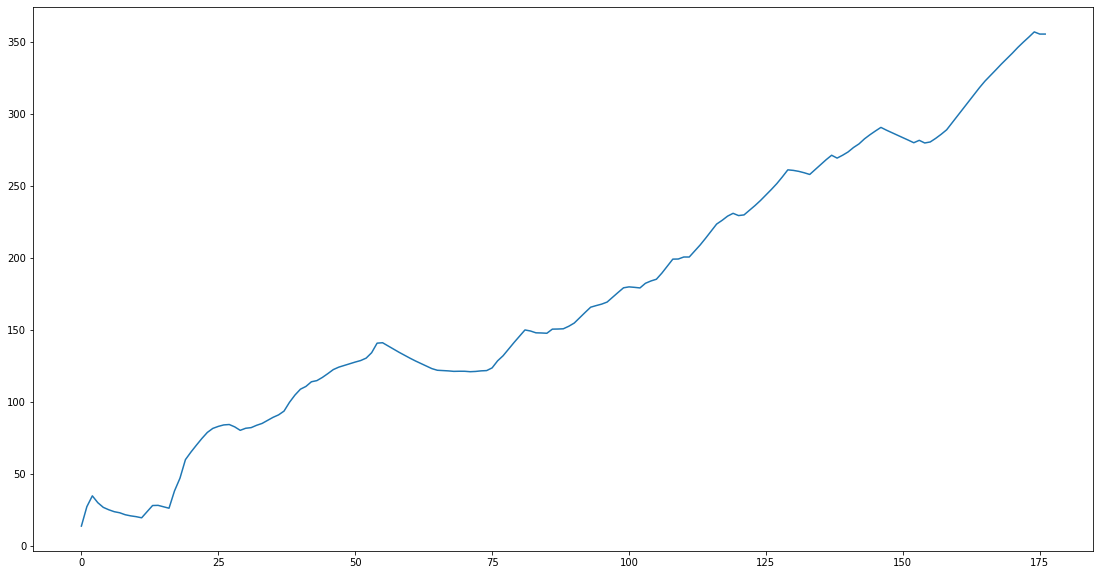

In [ ]:
plt.figure(figsize=(19,10))
plt.plot(range(len(avg_returns)), avg_returns)
plt.show()

In [ ]:
agent.network.save("dqn_experiment_1", save_format='tf')

In [ ]:
!zip -r /content/dqn_experiment_1.zip /content/dqn_experiment_1

  adding: content/dqn_experiment_1/ (stored 0%)
  adding: content/dqn_experiment_1/keras_metadata.pb (deflated 75%)
  adding: content/dqn_experiment_1/variables/ (stored 0%)
  adding: content/dqn_experiment_1/variables/variables.data-00000-of-00001 (deflated 59%)
  adding: content/dqn_experiment_1/variables/variables.index (deflated 41%)
  adding: content/dqn_experiment_1/assets/ (stored 0%)
  adding: content/dqn_experiment_1/saved_model.pb (deflated 86%)


In [ ]:
from google.colab import files